<a href="https://colab.research.google.com/github/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo3/cuadernos/Flujo_GAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **MÓDULO 3: APRENDIZAJE PROFUNDO**

## **Descripción**

Aplicación de redes neuronales para la simulación y predicciones de flujos de la red gasífera de Colombia.

### **Profesor - Sesión 5 y 6:** Diego Armando Pérez Rosero
### **Monitores - Sesión 5 y 6:** Danna Valentina Salazar Dubois, Juan Camilo Lugo Rojas y Lucas Miguel Iturriago Salas

In [1]:
# @title Configurar entorno
%%capture
!pip uninstall -y tensorflow tf-keras
!pip install tensorflow==2.15.1
!pip install visualkeras
!pip install spektral
!pip -q install torch_geometric
!git clone https://github.com/UN-GCPDS/curso_IA_CHEC.git

from tensorflow.python.ops.nn_ops import softmax
from keras import backend as k
import numpy as np
from matplotlib.gridspec import GridSpec
from IPython import display
from scipy.optimize import linprog
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Activation,Dense,Input,BatchNormalization,Dropout,Conv1D,Flatten,MaxPool1D,Dot,Reshape,Conv2D,Concatenate,ReLU,Lambda,MaxPooling2D,Normalization,Reshape
import cvxpy as cp
import tensorflow as tf
from keras import Model
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import warnings
import os
import pandas as pd
from IPython import display
path='/content/curso_IA_CHEC/Modulo3/database/'
from keras.models import Sequential
mse=mean_squared_error
mae=mean_absolute_error
mape=mean_absolute_percentage_error
warnings.filterwarnings("ignore")
from scipy.sparse import coo_matrix, eye, hstack
from tensorflow.keras.callbacks import Callback
import torch
from torch_geometric.utils import to_dense_adj
from spektral.layers import GCNConv
import pandas as pd
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import time
from keras.callbacks import Callback
import seaborn as sns
import os
from pathlib import Path
import scipy.io as sio

import ipywidgets as widgets
from IPython.display import display, clear_output


def model_op(loss: str ='huber') -> Model:
    """
    Create a Keras model with a set of dense layers and custom regularization.

    Returns:
        A Keras Model object.
    """
    input_tensor = Input(shape=(2,))
    regularization_strength = 1e-1
    learning_rate = 1e-3
    layer = input_tensor
    for i in range(1, 5):
        layer = Dense(
            32,
            activation='selu',
            kernel_regularizer=regularizers.L1L2(
                l1=regularization_strength,
                l2=regularization_strength
            ),
            name=f'Dense_{i}'
        )(layer)

    weights = Dense(
        2,
        activation='selu',
        kernel_regularizer=regularizers.L1L2(
            l1=regularization_strength,
            l2=regularization_strength
        ),
        name='W',
        kernel_constraint=tf.keras.constraints.MaxNorm(1)
    )(layer)

    output_tensor = tf.reduce_sum(tf.multiply(weights, input_tensor), axis=-1)
    output_tensor = Reshape((1,))(output_tensor)
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss = loss, optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

def GenW(Data_inf,Data_W,Data_T,Data_C,Data_Dc,Data_sto):
    N = len(Data_inf)
    W = len(Data_W)
    wells = coo_matrix((np.ones(W, ), (Data_W['node'] - 1, np.arange(W))), shape=(N, W))
    P = len(Data_T)
    data = np.concatenate((-1.0 * np.ones(P), np.ones(P)))
    row = pd.concat((Data_T['fnode'] - 1, Data_T['tnode'] - 1))
    col = np.concatenate(2 * [np.arange(P)])

    pipes = coo_matrix((data, (row, col)), shape=(N, P))

    C = len(Data_C)
    data = np.concatenate((-1.0 * np.ones(C), np.ones(C)))
    row = pd.concat((Data_C['fnode'] - 1, Data_C['tnode'] - 1))
    col = np.concatenate(2 * [np.arange(C)])
    comps = coo_matrix((data, (row, col)), shape=(N, C))
    users=hstack(len(Data_Dc.T) * [eye(N)])
    S = len(Data_sto)
    sto = coo_matrix((np.ones(S, ), (Data_sto['node'] - 1, np.arange(S))), shape=(N, S))
    sto = hstack([sto, -1.0 * sto])
    w=(hstack((wells, pipes, comps, users, sto))).toarray()
    return w

def split(F_d,F_O):
    y=F_O
    X_train,X_test,y_train, y_test = train_test_split(F_d,y,test_size=0.2)
    return X_train,X_test,y_train, y_test


def flow(C,li,name,e,initializer):
    #D=Dense(1024,activation='selu',kernel_initializer=initializer)(C)
    D=BatchNormalization()(C)
    D=Dense(len(li),name=name,activation=e,kernel_initializer=initializer)(D)

    return D
def pres(C,li,ls,name,initializer):
    D=BatchNormalization()(C)
    D=Dense(len(li),name=name,activation=custom_activation1(li,ls),kernel_initializer=initializer)(C)
    return D

def Flujos(model,X_test):
    model_B = tf.keras.Model(inputs=model.inputs,outputs=model.get_layer('Flujos').output)
    F=model_B.predict(X_test,verbose=False)
    return F

class custom_activation1:
    def __init__(self, lower_bound, upper_bound):
        self.li=tf.cast(lower_bound, tf.float32)
        self.ls=tf.cast(upper_bound, tf.float32)

    def __call__(self, x):
        x=tf.cast(x, tf.float32)
        x=tf.sigmoid(x)*(self.ls-self.li)+self.li
        return x

    def get_config(self):
        return {
            "lower_bound": self.li,
            "upper_bound": self.ls
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class LRReducer(Callback):
    def __init__(self, epoch_threshold):
        super(LRReducer, self).__init__()
        self.epoch_threshold = epoch_threshold

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epoch_threshold:
            lr = float(self.model.optimizer.lr)
            new_lr = lr * 0.1
            self.model.optimizer.lr.assign(new_lr)

class WellDense(tf.keras.layers.Layer):
    def __init__(self, well=80.0, **kwargs):
        super(WellDense, self).__init__(**kwargs)
        self.well = tf.Variable(initial_value=well, trainable=False, dtype=tf.float32)
    def call(self, inputs):
        x = inputs
        w = tf.reduce_sum(x, axis=1, keepdims=True)
        w = tf.where(w >= self.well, self.well, w)
        return w
    def get_config(self):
        config = super(WellDense, self).get_config()
        config.update({"well": self.well.numpy()})
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)


class RestrictedDense(tf.keras.layers.Layer):
    def __init__(self, initializer, well, units, **kwargs):
        super().__init__(**kwargs)
        self.initializer = initializer
        self.units = units
        self.well = tf.constant(well, dtype=tf.float32)


    def call(self, inputs):
        x, In, fw = inputs
        x = tf.where(x <= 0., 0., x)
        x = tf.where(x <= In, x, In)
        mask = tf.where(tf.reduce_sum(In, axis=-1, keepdims=True) <= self.well, 0.0, 1.0)
        x = x * mask
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "initializer": tf.keras.initializers.serialize(self.initializer),
            "well": self.well,
            "units": self.units
        })
        return config
    @classmethod
    def from_config(cls, config):
        config['initializer'] = tf.keras.initializers.deserialize(config['initializer'])
        return cls(**config)

class custom_loss2(tf.keras.losses.Loss):
    def __init__(self, Kt, i, j, Bc, ic, jc, find=6, s=0, name="Wey"):
        super().__init__(name=name)
        self.Kt = Kt
        self.i = i
        self.j = j
        self.Bc = Bc
        self.ic = ic
        self.jc = jc
        self.find = find
        self.s = s
        self.lower_bound = tf.constant(1.0, dtype=tf.float32)
        self.upper_bound = tf.constant(Bc, dtype=tf.float32)

    def call(self, y_true, y_pred):
        f = tf.cast(y_pred[:, :self.find], tf.float32)
        P = tf.cast(y_pred[:, self.find:], tf.float32)
        pi = tf.gather(P, self.i, axis=1)
        pj = tf.gather(P, self.j, axis=1)
        loss = tf.keras.losses.huber(f, tf.sign(pi**2-pj**2)*tf.sqrt(self.Kt*tf.abs(pi**2-pj**2)))

        P_ic = tf.gather(P, self.ic, axis=1)
        P_jc = tf.gather(P, self.jc, axis=1)
        h = self.upper_bound + self.lower_bound
        h1 = self.upper_bound - self.lower_bound
        PjPi = tf.math.divide_no_nan(P_jc, P_ic)  # Asumiendo que P_jc y P_ic están definidos
        PjPi_rounded = tf.round(PjPi * 1000) / 1000
        condition = tf.math.logical_and(  PjPi  >= self.lower_bound,PjPi <= self.upper_bound)
        Penalty = tf.reduce_mean(tf.where(condition, 0.0, tf.square((PjPi-0.5*h)/h1)))
        return loss
class custom_loss3(tf.keras.losses.Loss):
    def __init__(self, Kt, i, j, Bc, ic, jc, find=6, s=0, name="Ratio"):
        super().__init__(name=name)
        self.Kt = Kt
        self.i = i
        self.j = j
        self.Bc = Bc
        self.ic = ic
        self.jc = jc
        self.find = find
        self.s = s
        self.lower_bound = tf.constant(1.0, dtype=tf.float32)
        self.upper_bound = tf.constant(Bc, dtype=tf.float32)

    def call(self, y_true, y_pred):
        f = tf.cast(y_pred[:, :self.find], tf.float32)
        P = tf.cast(y_pred[:, self.find:], tf.float32)
        pi = tf.gather(P, self.i, axis=1)
        pj = tf.gather(P, self.j, axis=1)
        loss = tf.keras.losses.huber(f, tf.sign(pi**2-pj**2)*tf.sqrt(self.Kt*tf.abs(pi**2-pj**2)))

        P_ic = tf.gather(P, self.ic, axis=1)
        P_jc = tf.gather(P, self.jc, axis=1)
        h = self.upper_bound + self.lower_bound
        h1 = self.upper_bound - self.lower_bound
        PjPi = tf.math.divide_no_nan(P_jc, P_ic)  # Asumiendo que P_jc y P_ic están definidos
        PjPi_rounded = tf.round(PjPi * 1000) / 1000
        condition = tf.math.logical_and(  PjPi  >= self.lower_bound,PjPi <= self.upper_bound)
        Penalty = tf.reduce_mean(tf.where(condition, 0.0, tf.square((PjPi-0.5*h)/h1)))
        return Penalty

    def get_config(self):
        return {
            "Kt": self.Kt,
            "i": self.i,
            "j": self.j,
            "Bc": self.Bc,
            "ic": self.ic,
            "jc": self.jc,
            "find": self.find,
            "s": self.s
        }
    @classmethod
    def from_config(cls, config):
        return cls(**config)



class FixedWeightsConstraint(tf.keras.constraints.Constraint):
    def __init__(self, w):
        self.w = tf.constant(w.T, dtype=tf.float32)  # Asegúrate de que `w` está en el formato correcto antes de convertirlo a un tensor.

    def __call__(self, weights):
        return self.w

    def get_config(self):
        return {"w": self.w.numpy().tolist()}  # Convierte el tensor a lista para la serialización.

    @classmethod
    def from_config(cls, config):
        return cls(w=config["w"])


def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))
def swish(x):
    return x*tf.sigmoid(x)


def flow_model(path, fd,U1,U2,a,b,c, s=1,G=1):
    """
    Builds and compiles a TensorFlow Keras model based on data from an Excel file and additional parameters.

    Parameters:
    - path (str): Path to the Excel file containing the model's data.
    - fd (array-like): Additional flow data for the model.
    - seeds (int): Seed for random number generation for reproducibility.
    - s (int): Mode switch for the model configuration.

    Returns:
    - tensorflow.keras.Model: The compiled Keras model.
    """
    Data_inf  =   pd.read_excel(path, sheet_name='node.info')
    Data_D    =   pd.read_excel(path, sheet_name='node.dem')
    Data_Dc   =   pd.read_excel(path, sheet_name='node.demcost')
    Data_W    =   pd.read_excel(path, sheet_name='well')
    Data_T    =   pd.read_excel(path, sheet_name='pipe')
    Data_C    =   pd.read_excel(path, sheet_name='comp')
    Data_sto  =   pd.read_excel(path, sheet_name='sto')
    w = GenW(Data_inf, Data_W, Data_T, Data_C, Data_Dc, Data_sto)
    N = w.shape[0]
    initializer = tf.keras.initializers.GlorotNormal()
    In = Input(shape=(N,))
    N1 = N
    edge_index = torch.tensor([[0, 3, 3, 4, 5, 4, 1, 2],
                           [1, 4, 5, 5, 6, 7, 2, 3]], dtype=torch.long)
    A = to_dense_adj(edge_index)[0].numpy().astype(int)
    N1 = N
    A = tf.convert_to_tensor(A)
    if G==0:
        x=Dense(w.shape[1]*4,'selu',kernel_regularizer=regularizers.L1L2(a,a))(In)
    else:
        x=Reshape((N,1))(In)
        x=GCNConv(w.shape[1]*4,'selu',)([x,A])
        x=Flatten()(x)

    F = []
    if s == 0:
        Li = np.concatenate((Data_T['Fg_min'].values, [0] * len(Data_C), Data_D['Res'].values * 0.0, Data_D['Ind'].values * 0.0, Data_D['Com'].values * 0.0,
                            Data_D['NGV'].values * 0.0, Data_D['Ref'].values*0.0,
                            Data_D['Pet'].values * 0.0, [0] * len(Data_sto.values) * 2))
        Ls = np.concatenate((Data_T['Fg_max'].values, Data_C['fmaxc'].values, fd, Data_D['Ind'].values * 0.0, Data_D['Com'].values * 0.0, Data_D['NGV'].values * 0.0, Data_D['Ref'].values * 0.0, Data_D['Pet'].values * 0.0,
                            (Data_sto['V0'].values - Data_sto['V_max'].values) * 0.0, (Data_sto['Vmax'].values - Data_sto['V0'].values) * 0.0))
        F = []
        F0 = WellDense(well=Data_W['Imax'].values[0], name='F_0')(In)
        F1 = flow(x,Li,'F_1',custom_activation1(Li,Ls),initializer)
        F = Concatenate(name='F')([F0, F1])  # ,F2,F3])

    elif s == 1:
        fdin = len(Data_W['Imin'].values) + \
            len([0] * len(Data_T)) + len([0] * len(Data_C))
        fdfn = len([0] * len(Data_sto.values) * 2) + \
            len(Data_inf['Pmin'].values)
        F0 = WellDense(well=Data_W['Imax'].values[0], name='F_0')(In)
        Li = Data_T['Fg_min'].values
        Ls = Data_T['Fg_max'].values
        F1 =flow(x,Li,'F_1',custom_activation1(Li,Ls),initializer)

        Li = [0] * len(Data_C)
        Ls = Data_C['fmaxc'].values
        F2 = flow(x,Li,'F_2',custom_activation1(Li,Ls),initializer)
        xt=Dense(N1,'selu',kernel_regularizer=regularizers.L1L2(b,b),kernel_initializer=initializer)(x)
        xt=BatchNormalization()(xt)
        F3 = RestrictedDense(
            initializer=initializer, well=Data_W['Imax'].values[0], name='F_3', units=len(Data_inf))([xt, In, F0])
        Li=np.concatenate((Data_D['Ind'].values*0.0,Data_D['Com'].values*0.0,Data_D['NGV'].values*0.0,Data_D['Ref'].values*0.0,
                        Data_D['Pet'].values*0.0,[0]*len(Data_sto.values)*2))
        Ls=np.concatenate((Data_D['Ind'].values*0.0,Data_D['Com'].values*0.0,Data_D['NGV'].values*0.0,Data_D['Ref'].values*0.0,Data_D['Pet'].values*0.0,
                    (Data_sto['V0'].values-Data_sto['V_max'].values)*0.0,(Data_sto['Vmax'].values-Data_sto['V0'].values)*0.0))
        F4=flow(In,Li,'F_4',custom_activation1(Li,Ls),initializer)
        F = Concatenate(name='F')([F0, F1, F2, F3, F4])

    Out1=Dense(units=w.shape[0],use_bias=False,kernel_constraint=FixedWeightsConstraint(w),name='Bal')(F)

    Kt=tf.constant(Data_T['Kij'].values,dtype=tf.float32)
    i=Data_T['fnode'].values-1
    j=Data_T['tnode'].values-1
    ftin=len(Data_W)
    ftfn=len(Data_T)
    f=F[:,ftin:ftfn+ftin]
    Li=Data_inf['Pmin'].values
    Ls=Data_inf['Pmax'].values
    ib=Data_C['fnode'].values-1
    jb=Data_C['tnode'].values-1


    if G==0:
        x1=Dense(w.shape[1]*4,'selu',kernel_regularizer=regularizers.L1L2(c,c),kernel_initializer=initializer)(In)
        x1=BatchNormalization()(x1)
    else:
        x=Reshape((-1,1))(F1)
        x1=Flatten()(x)
        x1=Dense(w.shape[1]*4,'selu',kernel_regularizer=regularizers.L1L2(c,c),kernel_initializer=initializer)(F1)
        x1=BatchNormalization()(x1)
        #x=GCNConv(8,'selu')([x,A])


        #x1=Dense(w.shape[1]*4,'selu',kernel_regularizer=regularizers.L1L2(c,c),kernel_initializer=initializer)(x1)
        #x1=BatchNormalization()(x1)

    #x1=Dense(N1,'sigmoid',kernel_regularizer=regularizers.L1L2(c,c),kernel_initializer=initializer)(x1)
    #x1=BatchNormalization()(x1)
    P =pres(x1,Li,Ls,'P',initializer)

    Out2 = Concatenate(name='Wey')([f, P])
    Out3 = Concatenate(name='Ratio')([f, P])
    Bc = Data_C['ratio'].values

    model = Model(In, [Out1, Out2,Out3])
    model.compile(loss={'Bal': 'huber', 'Wey': custom_loss2(Kt,i,j,Bc,ib,jb,ftfn),'Ratio': custom_loss3(Kt,i,j,Bc,ib,jb,ftfn)},
                  optimizer=tf.keras.optimizers.Adamax(1e-2), loss_weights=[0.6, 0.1,0.3])
    return model


class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

def EvalBalance(FT,W,X):
    aux1=[]
    aux2=[]
    for i in range(len(FT[0])):
        aux1.append(mape(X[i],FT[0][i]@W.T))
        aux2.append(mape(X[i],FT[1][i]@W.T))
    return[aux1,aux2]

def EvalWeymouth(X,Y):
    aux1=[]
    aux2=[]
    for i in range(len(X[0])):
        aux1.append(mape(X[0][i],Y[0][i]))
        aux2.append(mape(X[1][i],Y[1][i]))
    return[aux1,aux2]

def EvalCost(X,Y):
    aux1=[]
    for i in range(len(X)):
        aux1.append(Y[i] - X[i])
    return aux1

def dividir_datos(array, indice_test):
    """
    Divide un array en conjuntos de entrenamiento y prueba basado en un índice dado y
    reorganiza el conjunto de entrenamiento a una nueva forma.

    Parámetros:
    - array: Array de entrada con dimensiones (10, 100, 8).
    - indice_test: Índice del sub-array a usar como conjunto de prueba.
a
    Retorna:
    - X_train_reshaped: Array con los datos de entrenamiento reorganizados.
    - X_test: Array con los datos de prueba.
    """
    # Verificar que el índice esté en el rango permitido
    if indice_test < 0 or indice_test >= array.shape[0]:
        raise ValueError("El índice debe estar entre 0 y 9.")

    # Usar el índice para seleccionar el conjunto de prueba y el resto para entrenamiento
    X_test = array[indice_test]
    X_train = np.delete(array, indice_test, axis=0)

    # Cambiar la forma de X_train de (9, 100, 8) a (900, 8)
    X_train_reshaped = np.concatenate(X_train)
    return X_train_reshaped, X_test

def print_model_summary_with_memory(model):
    model.summary()  # Imprimir el resumen estándar

    total_memory = 0
    print("\n{:<20} {:<15}".format("Layer", "Memory (MB)"))
    print("="*35)

    # Iterar sobre cada capa y calcular la memoria usada por los pesos
    for layer in model.layers:
        layer_memory = 0
        for weight in layer.get_weights():
            layer_memory += weight.nbytes/1024  # Convertir bytes a MB
        total_memory += layer_memory
        print("{:<20} {:<15.2f}".format(layer.name, layer_memory))

    print("="*35)
    print(f"Total memory usage: {total_memory:.2f} KB")


## **Objetivo**:
Implementar técnicas de deep learning para optimizar sistemas de potencia alimentados por plantas termoeléctricas, utilizando redes neuronales informadas por principios físicos.

![Red completa](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo3/sources/red_completa.png?raw=1)

## **Optimización Lineal y No Lineal para Sistemas a Gas**




<img src="https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo3/sources/Diagrama.svg?raw=1" alt="Red completa" width="700">


Sistema a gas dependiente de flujo y presión

\begin{aligned}
    & \min_{\mathbf{x},\boldsymbol{\pi}} \quad  \mathbf{x}^\top\mathbf{a} \\
    & \text{s.t.} \quad  \quad \mathbf{B}\mathbf{x}=\mathbf{z}\\
    & \quad \quad \quad x_q=\text{sgn}\left(\pi_{w(q)}^{2}-\pi_{w'(q)}^{2}\right)\sqrt{k_q|\pi_{w(q)}^{2}-\pi_{w'(q)}^{2}|},\\
    & \quad \quad \quad \forall q\in Q; \quad w(q),w'(q)\in W\\
    & \quad \quad \quad {\beta}_{\text{min}}(n,n')\leq\frac{\pi_n}{\pi_{n'}}\leq {\beta}_{\text{max}}(n,n'), \quad \forall n,n'\in V\\
    & \quad \quad \quad \boldsymbol{\gamma}_{\text{min}}\leq \boldsymbol{\pi} \leq  \boldsymbol{\gamma}_{\text{max}}\\
    & \quad \quad \quad \boldsymbol{\delta}_{\text{min}}\leq \mathbf{x}\leq \boldsymbol{\delta}_{\text{max}},
\end{aligned}


---

Donde $\mathbf{a} \in \mathbb{R}^{P}$, $\mathbf{x} \in \mathbb{R}^{P}$, $\mathbf{B} \in \mathbb{R}^{W \times P}$, $\mathbf{z} \in \mathbb{R}^{W}$, $\boldsymbol{\pi} \in \mathbb{R}^{W}$, $k_q\in\mathbb{R}$, $\pi_{w(q)}, \pi_{n}, \pi_{n'} \in \boldsymbol{\pi}$, ${\beta}_{\text{min}}(n,n'), {\beta}_{\text{max}}(n,n') \in \mathbb{R}^+$, $\boldsymbol{\gamma}_{\text{min}}, \boldsymbol{\gamma}_{\text{max}} \in \mathbb{R}^{W}$ y $\boldsymbol{\delta}_{\text{min}}, \boldsymbol{\delta}_{\text{max}} \in \mathbb{R}^{P}$.


<table style="background-color: white; border-collapse: collapse;">
  <tr>
    <td style="background-color: white;">
      <img src="https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo3/sources/red_ocho_nodos.png?raw=1" alt="Imagen 1" width="400"/>
    </td>
    <td style="background-color: white;">
      <img src="https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo3/sources/red_gasifera_colombia.png?raw=1" alt="Imagen 2" width="400"/>
    </td>
  </tr>
</table>

In [3]:
# @title **Selección de parámetros**
# Definición de la función para entrenar el modelo con los nuevos valores de U1 y U2
history = None
model = None
X_test=None
Data_inf = None
Data_T= None
def entrenar_modelo(U1, U2, Pmax, Pmin, Fg_max, Fg_min,path):
    global history
    global model
    global X_test
    global Data_inf
    global Data_T

    lr_reducer = LRReducer(epoch_threshold=[400, 500, 580])
    AJ = 'S'
    s = 1
    if AJ == 'D':
        ajus = [-12.4, -13, -2.8, -1.7, 0, 4, 8, 10, 10]
    elif AJ == 'M':
        ajus = [6.5, 8.7, 10.5, 11.9, 13.1, 14.1, 15, 15.8, 36]
    elif AJ == 'S':
        ajus = [12.4, 13.7, 14.8, 15.7, 16.4, 17.2, 17.8, 18.3, 48]

    # Cargar datos

    nodos = 8
    N = 20000

    if nodos == 18:
        path = path + 'ng_caseCol_' + str(nodos) + '.xlsx'
        ajusts = ajus[-1]
    else:
        path = path + 'ng_case' + str(nodos) + '.xlsx'
        ajusts = ajus[nodos - 8]

    Data_inf = pd.read_excel(path, sheet_name='node.info')
    Data_T = pd.read_excel(path, sheet_name='pipe')

    # Actualizar valores en Data_inf
    Data_inf['Pmax'] = Pmax
    Data_inf['Pmin'] = Pmin

    # Actualizar valores en Data_T
    Data_T['Fg_max'] = Fg_max
    Data_T['Fg_min'] = Fg_min



    N = 20000
    Data_D = pd.read_excel(path, sheet_name='node.dem')
    Data_Dc = pd.read_excel(path, sheet_name='node.demcost')
    Data_W = pd.read_excel(path, sheet_name='well')
    Data_C = pd.read_excel(path, sheet_name='comp')
    Data_sto = pd.read_excel(path, sheet_name='sto')

    Cost = np.concatenate((
        Data_W['Cg'].values,
        Data_T['C_O'].values,
        Data_C['costc'],
        Data_Dc['al_Res'].values,
        Data_Dc['al_Ind'].values,
        Data_Dc['al_Com'].values,
        Data_Dc['al_NGV'].values,
        Data_Dc['al_Ref'].values,
        Data_Dc['al_Pet'].values,
        Data_sto['C_S+'].values - Data_sto['C_V'].values,
        -1 * (Data_sto['C_S-'] - Data_sto['C_V']).values,
        Data_sto['C_V'].values
    )).reshape(-1, 1)

    cost = Cost
    w = GenW(Data_inf, Data_W, Data_T, Data_C, Data_Dc, Data_sto)
    min_value = Data_D.values.sum(axis=1).min()
    max_value = Data_D.values.sum(axis=1).max()

    # Crear el conjunto de datos de entrenamiento
    X_train, X_test = train_test_split(np.random.uniform(min_value, max_value - ajusts, (N, nodos)), shuffle=True, test_size=0.2)
    fd = np.array(X_train).max(axis=0)

    # Crear el modelo con los nuevos valores de U1 y U2
    model = flow_model(path, fd, U1=U1, U2=U2, a=1e-4, b=1e-4, c=1e-4, s=s, G=0)
    history = model.fit(X_train, X_train, epochs=300, validation_split=0.2, verbose=True, batch_size=256, callbacks=[lr_reducer])


# Widgets para cambiar los valores de U1, U2, Pmax, Pmin, Fg_max y Fg_min
U1_widget = widgets.IntSlider(value=256, min=128, max=512, step=32, description='U1:')
U2_widget = widgets.IntSlider(value=2048, min=1024, max=4096, step=256, description='U2:')
Pmax_widget = widgets.FloatSlider(value=1250, min=1000, max=1500, step=10, description='Pmax:')
Pmin_widget = widgets.FloatSlider(value=250, min=0, max=500, step=10, description='Pmin:')
Fg_max_widget = widgets.FloatSlider(value=80, min=0, max=100, step=5, description='Fg_max:')
Fg_min_widget = widgets.FloatSlider(value=-80, min=-100, max=0, step=5, description='Fg_min:')

# Botón para entrenar el modelo con los nuevos valores
button = widgets.Button(description='Entrenar Modelo')

# Función que se ejecuta al presionar el botón
def on_button_clicked(b):
    clear_output(wait=True)
    display(U1_widget, U2_widget, Pmax_widget, Pmin_widget, Fg_max_widget, Fg_min_widget, button)
    U1 = U1_widget.value
    U2 = U2_widget.value
    Pmax = Pmax_widget.value
    Pmin = Pmin_widget.value
    Fg_max = Fg_max_widget.value
    Fg_min = Fg_min_widget.value
    entrenar_modelo(U1, U2, Pmax, Pmin, Fg_max, Fg_min, path)

button.on_click(on_button_clicked)

# Mostrar los widgets y el botón
display(U1_widget, U2_widget, Pmax_widget, Pmin_widget, Fg_max_widget, Fg_min_widget, button)

IntSlider(value=256, description='U1:', max=512, min=128, step=32)

IntSlider(value=2048, description='U2:', max=4096, min=1024, step=256)

FloatSlider(value=1250.0, description='Pmax:', max=1500.0, min=1000.0, step=10.0)

FloatSlider(value=250.0, description='Pmin:', max=500.0, step=10.0)

FloatSlider(value=80.0, description='Fg_max:', step=5.0)

FloatSlider(value=-80.0, description='Fg_min:', max=0.0, min=-100.0, step=5.0)

Button(description='Entrenar Modelo', style=ButtonStyle())

Epoch 1/10
50/50 [==============================] - 11s 21ms/step - loss: 27.6604 - Bal_loss: 26.1400 - Wey_loss: 89.2613 - Ratio_loss: 10.0248 - val_loss: 22.5362 - val_Bal_loss: 22.9705 - val_Wey_loss: 81.0995 - val_Ratio_loss: 2.0133
Epoch 2/10
50/50 [==============================] - 1s 10ms/step - loss: 8.2189 - Bal_loss: 3.2545 - Wey_loss: 58.0436 - Ratio_loss: 1.4121 - val_loss: 11.2956 - val_Bal_loss: 7.1588 - val_Wey_loss: 66.0116 - val_Ratio_loss: 1.2072
Epoch 3/10
50/50 [==============================] - 1s 10ms/step - loss: 6.7806 - Bal_loss: 2.1997 - Wey_loss: 50.9703 - Ratio_loss: 1.0909 - val_loss: 10.0784 - val_Bal_loss: 6.9242 - val_Wey_loss: 56.3724 - val_Ratio_loss: 0.8352
Epoch 4/10
50/50 [==============================] - 1s 10ms/step - loss: 6.4664 - Bal_loss: 2.0969 - Wey_loss: 48.9538 - Ratio_loss: 0.9235 - val_loss: 8.3092 - val_Bal_loss: 4.4111 - val_Wey_loss: 53.3497 - val_Ratio_loss: 0.9722
Epoch 5/10
50/50 [==============================] - 0s 10ms/step - l

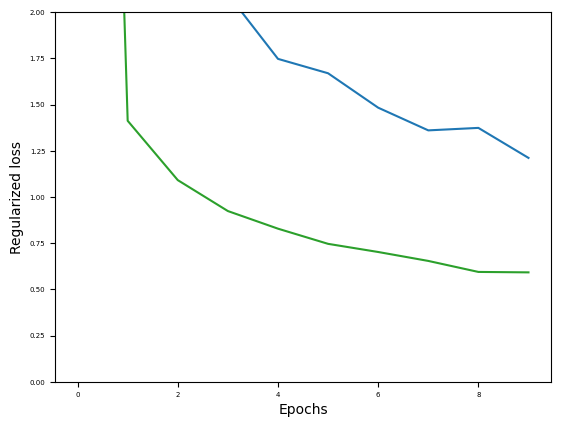

In [4]:
# @title **Desempeño de la red durante el entrenamiento**
plt.plot(history.history['Bal_loss'])
plt.plot(history.history['Wey_loss'])
plt.plot(history.history['Ratio_loss'])

plt.ylim([0,2])
plt.xlabel('Epochs')

plt.ylabel('Regularized loss')
plt.tick_params(axis='x', labelsize=5)  # Ajusta el tamaño de las etiquetas del eje x
plt.tick_params(axis='y', labelsize=5)  # Ajusta el tamaño de las etiquetas del eje y
plt.savefig('/content/LossG.pdf',bbox_inches='tight')
plt.show()

In [10]:
# @title **Salidas del modelo**
def gen_w(Data_inf, Data_W, Data_T, Data_C, Data_Dc, Data_sto):
    if not all(isinstance(data, pd.DataFrame) for data in [Data_W, Data_T, Data_C, Data_Dc, Data_sto]):
        raise ValueError("All data inputs must be pandas DataFrames")

    num_nodes = len(Data_inf)
    num_wells = len(Data_W)
    wells_matrix = coo_matrix((np.ones(num_wells, ), (Data_W['node'] - 1, np.arange(num_wells))), shape=(num_nodes, num_wells))

    num_pipes = len(Data_T)
    pipe_data = np.concatenate((-1.0 * np.ones(num_pipes), np.ones(num_pipes)))
    pipe_row = pd.concat((Data_T['fnode'] - 1, Data_T['tnode'] - 1))
    pipe_col = np.concatenate(2 * [np.arange(num_pipes)])
    pipes_matrix = coo_matrix((pipe_data, (pipe_row, pipe_col)), shape=(num_nodes, num_pipes))

    num_compressors = len(Data_C)
    compressor_data = np.concatenate((-1.0 * np.ones(num_compressors), np.ones(num_compressors)))
    compressor_row = pd.concat((Data_C['fnode'] - 1, Data_C['tnode'] - 1))
    compressor_col = np.concatenate(2 * [np.arange(num_compressors)])
    compressors_matrix = coo_matrix((compressor_data, (compressor_row, compressor_col)), shape=(num_nodes, num_compressors))

    num_users = len(Data_Dc.T)
    users_matrix = hstack(num_users * [eye(num_nodes)])

    num_storages = len(Data_sto)
    storage_matrix = coo_matrix((np.ones(num_storages, ), (Data_sto['node'] - 1, np.arange(num_storages))), shape=(num_nodes, num_storages))
    storage_matrix = hstack([storage_matrix, -1.0 * storage_matrix])

    result_matrix = hstack((wells_matrix, pipes_matrix, compressors_matrix, users_matrix, storage_matrix)).toarray()

    return result_matrix

def bounded(model, X_test, s1='/content/curso_IA_CHEC/Modulo3/database/'):
    s1_path = Path(s1)
    X_test = X_test
    filepath = ['ng_case8.xlsx', 'ng_case9.xlsx', 'ng_case10.xlsx', 'ng_case11.xlsx', 'ng_case12.xlsx', 'ng_case13.xlsx', 'ng_case14.xlsx', 'ng_case15.xlsx', 'ng_caseCol_18.xlsx']
    Weymouth = pd.DataFrame()
    Balance = pd.DataFrame()
    Costos = pd.DataFrame()
    PjPi = pd.DataFrame()
    im = 0
    path = s1_path / filepath[im]

    Data_D = pd.read_excel(path, sheet_name='node.dem')
    Data_Dc = pd.read_excel(path, sheet_name='node.demcost')
    Data_W = pd.read_excel(path, sheet_name='well')
    Data_C = pd.read_excel(path, sheet_name='comp')
    Data_T = pd.read_excel(path, sheet_name='pipe')
    Data_sto = pd.read_excel(path, sheet_name='sto')

    w = gen_w(Data_D, Data_W, Data_T, Data_C, Data_Dc, Data_sto)

    model_A = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer('F').output)
    model_B = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer('P').output)

    Fe = model_A.predict(np.array(X_test), verbose=False)
    Pe = model_B.predict(np.array(X_test), verbose=False)

    Fwe = Fe[:, 0:1]
    Fte = Fe[:, 1:1 + len(Data_T)]
    Fce = Fe[:, 1 + len(Data_T):1 + len(Data_T) + len(Data_C)]

    return Fwe, Fte, Fce, Pe, Data_W, Data_T, Data_C, Data_D, Data_inf

def plot_graph(graph_type, Fwe, Fte, Fce, Pe, Data_W, Data_T, Data_C, Data_inf):
    fig, axs = plt.subplots(figsize=(10, 6))

    fontsize = 15
    if graph_type == 'Gas Injection':
        sns.violinplot(data=Fwe, inner='box', cut=0, color='lightgreen', ax=axs)
        axs.set_ylabel('Gas Injection [MMSCFD]', fontsize=fontsize)
        axs.set_xlabel('Injection Node', fontsize=fontsize)
        axs.plot(0, Data_W['Imax'].values, 'k*', markersize=15)
    elif graph_type == 'Gas Flow (Pipelines)':
        sns.violinplot(data=Fte, inner='box', cut=0, color='lightgreen', ax=axs)
        axs.set_ylabel('Gas Flow [MMSCFD]', fontsize=fontsize)
        axs.set_xlabel('Pipeline Node', fontsize=fontsize)
        Li = Data_T['Fg_min'].values
        Ls = Data_T['Fg_max'].values
        axs.plot(np.arange(0, len(Data_T)), Ls, 'k*', markersize=15)
        axs.plot(np.arange(0, len(Data_T)), Li, 'k*', markersize=15)
    elif graph_type == 'Gas Flow (Compressors)':
        sns.violinplot(data=Fce, inner='box', cut=0, color='lightgreen', ax=axs)
        axs.set_ylabel('Gas Flow [MMSCFD]', fontsize=fontsize)
        axs.set_xlabel('Compressor Node', fontsize=fontsize)
        Li = [0] * len(Data_C)
        Ls = Data_C['fmaxc'].values
        axs.plot(np.arange(0, len(Data_C)), Ls, 'k*', markersize=15)
    elif graph_type == 'Pressure':
        sns.violinplot(data=Pe, inner='box', cut=0, color='lightgreen', ax=axs)
        axs.set_ylabel('Pressure [psia]', fontsize=fontsize)
        axs.set_xlabel('Pressure Node', fontsize=fontsize)
        Li = Data_inf['Pmin'].values
        Ls = Data_inf['Pmax'].values
        axs.plot(np.arange(0, Pe.shape[1]), Ls + 10, 'k*', markersize=15)
        axs.plot(np.arange(0, Pe.shape[1]), Li, 'k*', markersize=15)
    plt.grid(True)
    plt.show()

# Interfaz interactiva
def interactive_plot(model, X_test, Data_inf):
    Fwe, Fte, Fce, Pe, Data_W, Data_T, Data_C, Data_D, Data_inf = bounded(model, X_test)

    graph_options = ['Gas Injection', 'Gas Flow (Pipelines)', 'Gas Flow (Compressors)', 'Pressure']
    graph_dropdown = widgets.Dropdown(options=graph_options, description='Seleccionar gráfica:')

    def update_plot(graph_type):
        plot_graph(graph_type, Fwe, Fte, Fce, Pe, Data_W, Data_T, Data_C, Data_inf)

    widgets.interact(update_plot, graph_type=graph_dropdown)

interactive_plot(model, X_test, Data_inf)


interactive(children=(Dropdown(description='Seleccionar gráfica:', options=('Gas Injection', 'Gas Flow (Pipeli…